# import libraries and define functions
If plots in the following sections looks not as expected, please run this section again

In [30]:
from __future__ import print_function
import mpld3
import os
import math
import pandas
import numpy as np

from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib import rcParams

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


%matplotlib notebook
mpld3.enable_notebook()

rcParams['figure.figsize'] = [9, 4.5]
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True

rcParams.update({'figure.autolayout': True})
rcParams.update({'axes.labelsize': 20})
rcParams.update({'xtick.labelsize': 12})
rcParams.update({'ytick.labelsize': 12})
rcParams.update({'legend.frameon': False})
rcParams.update({'legend.fontsize': 10})
# personalize color sequence
rcParams.update(
    {
        'axes.prop_cycle':
        "cycler('color', ['black', 'red', 'green', 'blue', 'cyan', 'magenta', 'ff6600'])"
    }
)


# read in prodata csv file
def load_data(filename):
    # prodata sx may generate 2 formats
    # and the number of skip lines may vary
    f = open(filename)
    lines = f.readlines()
    skiprows = 0
    invert = False
    try:
        skiprows = lines.index("Time,Wavelength\n")
    except ValueError:
        try:
            skiprows = lines.index("Wavelength,Time\n")
            invert = True
        except ValueError:
            raise Exception("cannot determine number of rows to skip!")
    df = pandas.read_table(
        filename,  # file name
        skiprows=skiprows,  # leading rows that should not be read-in
        delimiter=',',
        header=1,
        index_col=0,
        nrows=1000,
        engine='python'
    ).dropna(axis='columns', how='any')
    df.columns = df.columns.map(float)
    df.index = df.index.map(float)
    if (invert):
        df = df.T
    return df


# plot all kinetic curves
def plot_all_kinetic(df, axis):
    df.plot.line(
        ax=axis,  # plot in the defined axis
        logx=True,
        xlim=(float(df.index[0]), float(df.index[-1])),
        legend=None
    )
    axis.set_xlabel("time (s)", fontsize=20)
    axis.set_ylabel("Abs", fontsize=20)


# plot all spectra
def plot_all_spectra(df, axis):
    df.plot.line(
        ax=axis,
        logx=False,
        xlim=(float(df.index[0]), float(df.index[-1])),
        legend=None
    )
    axis.set_xlabel("wavelength (nm)", fontsize=20)
    axis.set_ylabel("Abs", fontsize=20)


# plot selected curves
def replot(df, axis=None, mode='kinetic_trace', values=None, shifts=None, scales=None,
           logxFlag=False, colors=None, clean=True):
    if axis is None:
        fig = plt.figure()    # define a figure
        axis = fig.gca()    # define an axis
    if (mode == 'kinetic_trace'):
        inputDescription = "input (nm)"
        axis.set_xlabel('time (s)', fontsize=16)
    else:
        inputDescription = 'input (s)'
        axis.set_xlabel('wavelength (nm)', fontsize=16)
    axis.set_ylabel('Abs', fontsize=16)
    # if not given specific values, plot all
    if values is None:
        values = df.columns
    n = len(values)
    # give default values to shift and scale
    if shifts is None:
        shifts = [0] * n
    if scales is None:
        scales = [1] * n
    if colors is None:
        line_colors = plt.rcParams['axes.prop_cycle'].by_key()[
            'color']  # default colors
        line_colors = ['black', 'red', 'blue', 'green', 'cyan',
                       'magenta', 'orange', 'purple', 'olive']  # custom colors
    # delete existing lines
    if clean:
        for i in range(len(axis.lines)):
            line = axis.lines.pop(0)
            del line
    # plot new lines
    for i in range(n):
        value = values[i]
        index = abs(df.columns - value * np.ones(len(df.columns))).argmin()

        shift = shifts[i]
        scale = scales[i]
        (df.iloc[:, index:index+1]*scale+shift).plot.line(
            ax=axis,
            logx=logxFlag,
            xlim=(df.index[0], df.index[-1]),
            color=colors[i],
        )
        handles, labels = axis.get_legend_handles_labels()
        labels = list(map(lambda s: "%.3f" % float(s), labels))
        axis.legend(handles, labels).set_draggable(True)
        axis.relim()
        axis.autoscale(enable=True, axis='y')
        axis.figure.canvas.draw_idle()


# plot selected curves
def plot_selected_curves(df, mode='kinetic_trace', selected_values=[], axis=None, logxFlag=False, clean=True):
    # plot n kinetic curves, n can be customed. configure n, and press ctrl+Enter
    # before running this, please run the cell in which load_data() is defined
    n = len(selected_values)
    if (mode == 'kinetic_trace'):
        inputDescription = "input (nm)"
    else:
        inputDescription = 'input (s)'
    if axis is None:
        fig = plt.figure()    # define a figure
        axis = fig.gca()    # define an axis

    line_colors = plt.rcParams['axes.prop_cycle'].by_key()[
        'color']  # default colors
#     line_colors = ['black', 'red', 'blue', 'green']  # custom colors

    color_ranges = []
    value_inputs = []
    shift_ranges = []
    scale_ranges = []

    # replot when value changes
    def on_value_change(change):
        values = [value_input.value for value_input in value_inputs]
        shifts = [shift_range.value for shift_range in shift_ranges]
        scales = [scale_range.value for scale_range in scale_ranges]
        colors = [color_range.value for color_range in color_ranges]
        replot(df, axis=axis, values=values, shifts=shifts,
               scales=scales, colors=colors, logxFlag=logxFlag, mode=mode, clean=clean)

    # define initial values of slide bar and input text
    for i in range(n):
        color_ranges.append(widgets.ColorPicker(
            concise=False, description='line ' + str(i) + ' color', value=line_colors[i], continuous_update=True
        ))
        minVal = df.columns.values[0]
        maxVal = df.columns.values[-1]
        step = (maxVal-minVal)/len(df.columns)
        if mode == 'kinetic_trace':
            slider = widgets.FloatSlider(
                min=minVal, max=maxVal, step=step, description=inputDescription,
                continuous_update=True, readout_format='.2f',
            )
        else:
            slider = widgets.FloatLogSlider(
                base=10, min=math.log10(minVal), max=math.log10(maxVal), step=step,
                description=inputDescription, continuous_update=True, readout_format='.3f',
            )
        value_inputs.append(slider)

        play = widgets.Play(
            interval=100,
            #             value=slider.value,
            min=minVal,
            max=maxVal,
            step=step,
            description="Press play",
            disabled=False
        )

        shift_ranges.append(widgets.BoundedFloatText(
            value=0, min=-10, max=10, step=0.05, description='shift', readout_format='.2f', continuous_update=True
        ))
        scale_ranges.append(widgets.BoundedFloatText(
            value=1, min=0, max=10, step=0.05, description='scale', readout_format='.2f', continuous_update=True
        ))

        display(color_ranges[i])
        if mode == 'kinetic_trace':
            widgets.jslink((slider, 'value'), (play, 'value'))
            display(widgets.HBox([play, slider]))
        else:
            display(value_inputs[i])
        display(shift_ranges[i])
        display(scale_ranges[i])
        color_ranges[i].observe(on_value_change, names='value')
        value_inputs[i].observe(on_value_change, names='value')
        shift_ranges[i].observe(on_value_change, names='value')
        scale_ranges[i].observe(on_value_change, names='value')

    # set initial values, and trigger replot function
    for i in range(n):
        value_inputs[i].value = selected_values[i]

    return axis


# plot selected curves
def plot_multiple_selected_curves(inputFiles=[], mode='kinetic_trace', logxFlag=False):
    def f(df, axis, value):
        replot(df, axis=axis, mode=mode, values=[value], shifts=None, scales=None,
               logxFlag=logxFlag, colors=['black']*1000, clean=True)
    (row, col) = (1, len(inputFiles))
    if col == 0:
        return
    df = load_data(inputFiles[0])
    if mode == 'kinetic_trace':
        inputDescription = "input (nm)"
        minVal = df.columns.values[0]
        maxVal = df.columns.values[-1]
        step = (maxVal-minVal)/len(df.columns)
        slider = widgets.FloatSlider(
            min=minVal, max=maxVal, step=step, description=inputDescription,
            continuous_update=True, readout_format='.2f',
        )
    else:
        inputDescription = 'input (s)'
        df = df.T
        minVal = df.columns.values[0]
        maxVal = df.columns.values[-1]
        step = (maxVal-minVal)/len(df.columns)
        slider = widgets.FloatLogSlider(
            base=10, min=math.log10(minVal), max=math.log10(maxVal), step=step,
            description=inputDescription, continuous_update=True, readout_format='.3f',
        )
    fig, axs = plt.subplots(row, col, sharex=True, sharey=True)
    for i in range(col):
        axis = axs[i]
        df = load_data(inputFiles[i])
        if mode != 'kinetic_trace':
            df = df.T
        w = interactive(f, df=fixed(df), axis=fixed(axis), value=slider)
    play = widgets.Play(
        interval=100,
        #             value=slider.value,
        min=minVal,
        max=maxVal,
        step=step,
        description="Press play",
        disabled=False
    )
    if mode == 'kinetic_trace':
        widgets.jslink((slider, 'value'), (play, 'value'))
        display(widgets.HBox([play, slider]))
    else:
        display(slider)


# select part of the df according to given values
def get_selected_columns_as_dataframe(df, values=None, shifts=None, scales=None):
    if values is None:
        values = df.columns
    n = len(values)
    # give default values to shift and scale
    if shifts is None:
        shifts = [0] * n
    if scales is None:
        scales = [1] * n
    # build new dataframe
    dfResult = pandas.DataFrame()
    for i in range(n):
        value = values[i]
        index = abs(df.columns - value * np.ones(len(df.columns))).argmin()
        shift = shifts[i]
        scale = scales[i]
        dfResult = dfResult.append(df.iloc[:, index:index+1]*scale+shift)
    return dfResult

# plot kinetic curve and full spectra

<IPython.core.display.Javascript object>


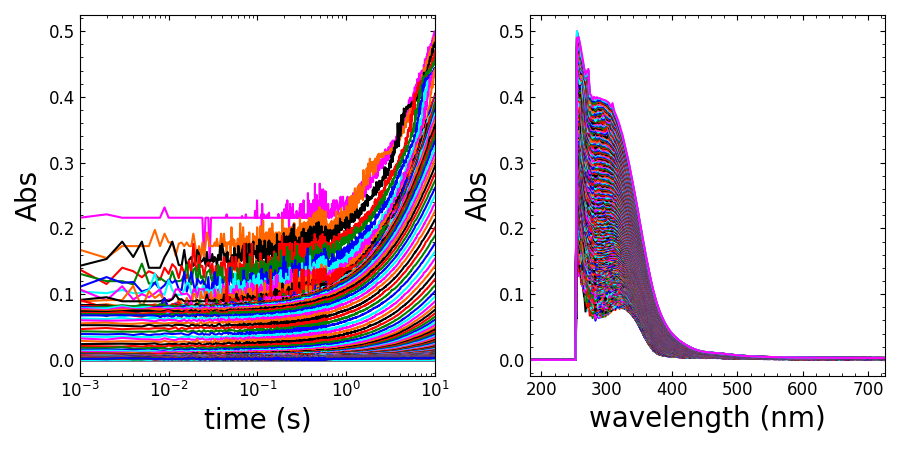

In [31]:
rcParams['figure.figsize'] = [9, 4.5]
csvfile = 'average-sample-10s-1.csv'
df = load_data(csvfile)
df1 = df
df2 = df.T
(row, col) = (1, 2)
fig, axs = plt.subplots(row, col, sharex=False, sharey=False)
axis1 = axs[0]  # first axis
axis2 = axs[1]  # second axis

plot_all_kinetic(df1, axis1)
plot_all_spectra(df2, axis2)

# make difference spectra

<IPython.core.display.Javascript object>


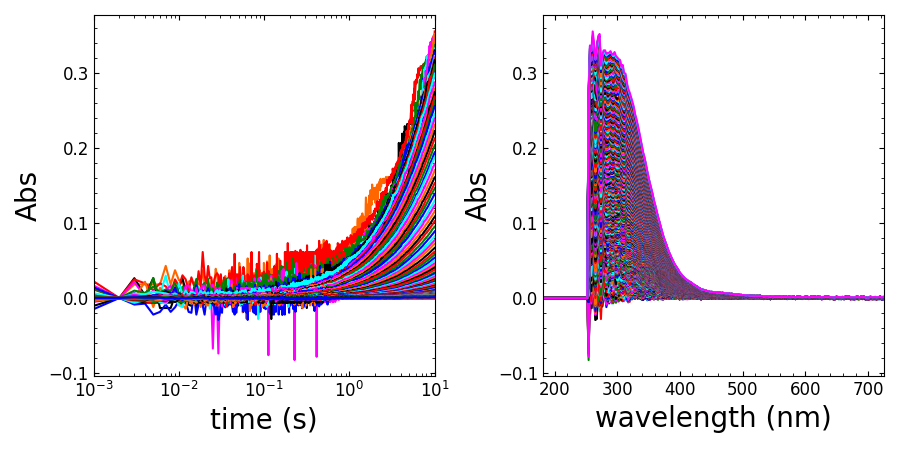

In [32]:
rcParams['figure.figsize'] = [9, 4.5]
df = load_data(csvfile)
baseCurve = df.iloc[1,:] # select the second time point as baseline
diffDf = df - baseCurve
df1 = df - baseCurve
df2 = df1.T
(row, col) = (1, 2)
fig, axs = plt.subplots(row, col, sharex=False, sharey=False)
axis1 = axs[0]  # first axis
axis2 = axs[1]  # second axis

plot_all_kinetic(df1, axis1)
plot_all_spectra(df2, axis2)

# plot selected kinetic traces

<IPython.core.display.Javascript object>


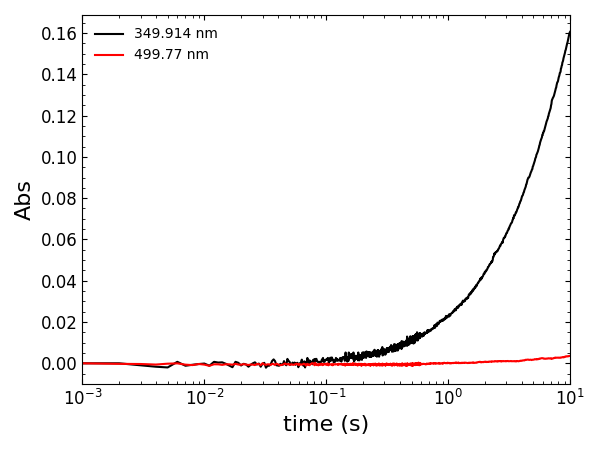

ColorPicker(value='black', description='line 0 color')

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

ColorPicker(value='red', description='line 1 color')

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

In [33]:
rcParams['figure.figsize'] = [6, 4.5]
df = load_data(csvfile)
# baseCurve = df.loc[0.002] # select 0.002s as difference baseline
baseCurve = df.iloc[0,:] # select the second time point as baseline
diffDf = df - baseCurve
axis = plot_selected_curves(diffDf, selected_values=[350, 500], logxFlag=True)
handles, labels = axis.get_legend_handles_labels()
labels = list(map(lambda s: s+' nm', labels))
axis.legend(handles, labels).set_draggable(True)

# plot selected full spectra

<IPython.core.display.Javascript object>


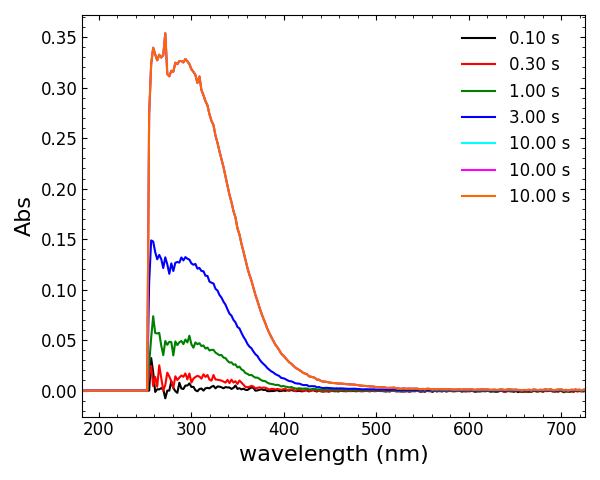

ColorPicker(value='black', description='line 0 color')

FloatLogSlider(value=1.0, description='input (s)', max=1.0, min=-3.0, readout_format='.3f', step=0.00999900000…

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

ColorPicker(value='red', description='line 1 color')

FloatLogSlider(value=1.0, description='input (s)', max=1.0, min=-3.0, readout_format='.3f', step=0.00999900000…

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

ColorPicker(value='green', description='line 2 color')

FloatLogSlider(value=1.0, description='input (s)', max=1.0, min=-3.0, readout_format='.3f', step=0.00999900000…

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

ColorPicker(value='blue', description='line 3 color')

FloatLogSlider(value=1.0, description='input (s)', max=1.0, min=-3.0, readout_format='.3f', step=0.00999900000…

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

ColorPicker(value='cyan', description='line 4 color')

FloatLogSlider(value=1.0, description='input (s)', max=1.0, min=-3.0, readout_format='.3f', step=0.00999900000…

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

ColorPicker(value='magenta', description='line 5 color')

FloatLogSlider(value=1.0, description='input (s)', max=1.0, min=-3.0, readout_format='.3f', step=0.00999900000…

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

ColorPicker(value='#ff6600', description='line 6 color')

FloatLogSlider(value=1.0, description='input (s)', max=1.0, min=-3.0, readout_format='.3f', step=0.00999900000…

BoundedFloatText(value=0.0, continuous_update=True, description='shift', max=10.0, min=-10.0, step=0.05)

BoundedFloatText(value=1.0, continuous_update=True, description='scale', max=10.0, step=0.05)

In [34]:
rcParams.update({'xtick.labelsize': 12})
rcParams.update({'ytick.labelsize': 12})
rcParams.update({'legend.frameon': False})
rcParams.update({'legend.fontsize': 12})
rcParams['figure.figsize'] = 6, 4.8  # set figure size
df = load_data(csvfile)
# baseCurve = df.loc[0.002] # select 0.002s as difference baseline
baseCurve = df.iloc[0, :]  # select the second time point as baseline
diffDf = df - baseCurve
transDf = diffDf.T
axis = plot_selected_curves(diffDf.T, mode='full_spectra', selected_values=[0.1, 0.3, 1, 3, 10, 30, 90])
handles, labels = axis.get_legend_handles_labels()
labels = list(map(lambda s: ('%.2f' % float(s)+' s'), labels))
axis.legend(handles, labels).set_draggable(True)

# compare multiple inputs on selected lines

<IPython.core.display.Javascript object>


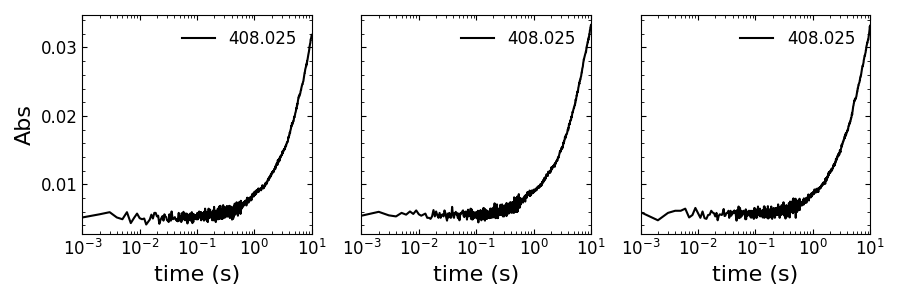

<IPython.core.display.Javascript object>


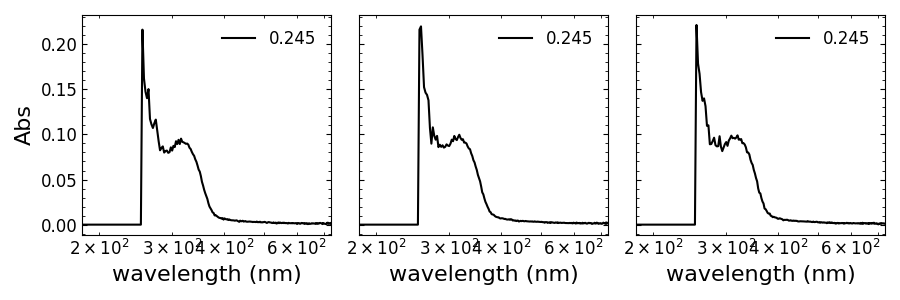

FloatLogSlider(value=1.0, description='input (s)', max=1.0, min=-3.0, readout_format='.3f', step=0.00999900000…

In [35]:
inputFiles = [
    'average-sample-10s-1.csv',
    'average-sample-10s-2.csv',
    'average-sample-10s-3.csv',
]
rcParams['figure.figsize'] = [9, 9/len(inputFiles)]
# fig = plt.figure()
plot_multiple_selected_curves(inputFiles=inputFiles, logxFlag=True)
plot_multiple_selected_curves(inputFiles=inputFiles, logxFlag=True, mode='full_spectra')

# save averaged files

In [37]:
from functools import reduce
import re
from datetime import datetime
csvfiles = [
    'average-sample-10s-1.csv',
    'average-sample-10s-2.csv',
    'average-sample-10s-3.csv',
]
dfSum = reduce((lambda df1, df2: df1 + df2), list(map(load_data, csvfiles)))
dfAve = dfSum / len(csvfiles)
# save to file
aveFileName = reduce((lambda s1, s2: s1 + s2),
                     re.split('.*/|-[0-9]+[.]csv', csvfiles[0])) + '-ave.csv'
aveFileName
with open(aveFileName, 'w') as f:
    f.write('Jupyter Notebook generated file, author - Yijie Tang (yijietang@cmu.edu)\n')
    f.write('Powered by python3, matplotlib, numpy, tkinter, jupyter\n')
    f.write('File generated at ' +str(datetime.now())+ '\n')
    f.write('This is an average file, source files are: \n')
    tabbedFileNames = list(map(lambda s: '\t'+s, csvfiles))
    f.write(reduce((lambda df1, df2: df1 + '\n' + df2), tabbedFileNames))
    for i in range(4):
        f.write('\n')
    f.write('Time,Wavelength\n')
dfAve.to_csv(float_format='%.6f', path_or_buf=aveFileName, mode='a', header=list(dfAve.columns.map(str)))

# export kintek input files

In [38]:
csvfile = 'kintek-sample-10s.csv'
df = load_data(csvfile)
kintekFileName = 'kintek-sample-10s-429nm.txt'
with open(kintekFileName, 'w') as f:
    f.write('Time')
dfPartial = get_selected_columns_as_dataframe(df, values=[429])
dfPartial.to_csv(sep='\t', float_format='%.6f', path_or_buf=kintekFileName, mode='a')

# plot original kinetic and kintek simulation

<IPython.core.display.Javascript object>


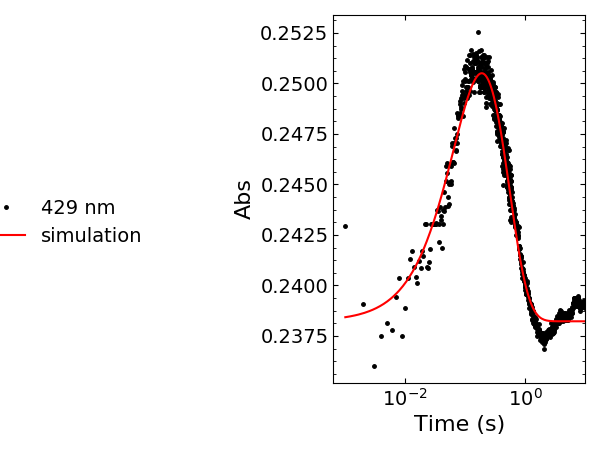

/home/yijie/.virtualenvs/jupyter-env/lib/python3.6/site-packages/pandas/plotting/_core.py:450: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(self.xlim)


In [40]:
rcParams['figure.figsize'] = [6, 4.5]
rcParams.update({'xtick.labelsize': 14})
rcParams.update({'ytick.labelsize': 14})
rcParams.update({'axes.labelsize':16})
rcParams.update({'legend.frameon': False})
rcParams.update({'legend.fontsize': 14})

kintekFileName = 'kintek-sample-10s-429nm.txt'
simFileName = 'kintek-sample-10s-429nm-sim.txt'
dfExp = pandas.read_table(
    kintekFileName,  # file name
    skiprows=0,  # leading rows that should not be read-in
    delimiter='\t',
    header=0,
    index_col=0,
#     nrows=1000,
    engine='python'
)
dfSim = pandas.read_table(
    simFileName,  # file name
    skiprows=0,  # leading rows that should not be read-in
    delimiter='\t',
    header=0,
    index_col=0,
#     nrows=1000,
    engine='python'
).dropna(axis='columns', how='any')

fig = plt.figure()
axis = fig.gca()
dfExp.plot.line(
    marker='.',
    markersize=5,
    linewidth=0,
    ax=axis,
    logx=True,
    xlim=(0,10),
    legend=None
)
dfSim.plot.line(
    ax=axis,
    logx=True,
    xlim=(0,10),
    legend=None
)
axis.set_xlabel('Time (s)')
axis.set_ylabel('Abs')
handles, labels = axis.get_legend_handles_labels()
labels = ['429 nm', 'simulation']
axis.legend(handles, labels).set_draggable(True)

# plot full spectra from different samples

<IPython.core.display.Javascript object>


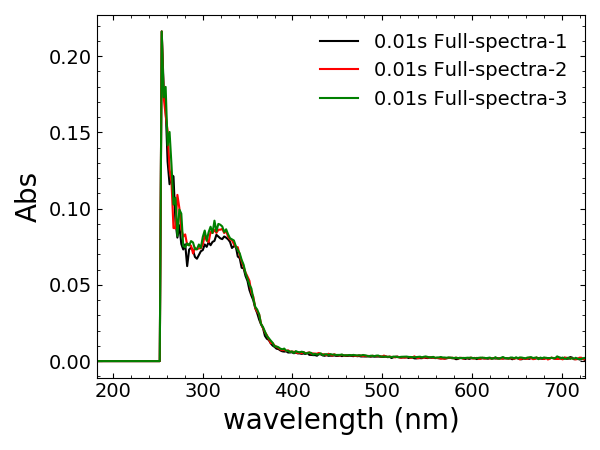

In [42]:
timepoint = 0.01
fig = plt.figure()
axis = fig.gca()
# plot curve 1
csvfile1 = 'average-sample-10s-1.csv'
df1 = get_selected_columns_as_dataframe(load_data(csvfile1).T, values=[timepoint])
plot_all_spectra(df1, axis)

# plot curve 2
scale = 1
shift = 0
csvfile2 = 'average-sample-10s-2.csv'
df2 = get_selected_columns_as_dataframe(load_data(csvfile2).T, values=[timepoint]) * scale + shift
plot_all_spectra(df2, axis)

# plot curve 3
scale = 1
shift = 0
csvfile3 = 'average-sample-10s-3.csv'
df3 = get_selected_columns_as_dataframe(load_data(csvfile3).T, values=[timepoint]) * scale + shift
plot_all_spectra(df3, axis)

# set labels and legends
axis.set_xlabel('wavelength (nm)')
axis.set_ylabel('Abs')
handles, labels = axis.get_legend_handles_labels()
labels_suffix = ["Full-spectra-1", "Full-spectra-2", 'Full-spectra-3']
labels = list( map(lambda s : s+'s ', labels) )
labels = list( map(add, labels, labels_suffix) )
axis.legend(handles, labels).set_draggable(True)

# plot kinetic curve from different spectra

<IPython.core.display.Javascript object>


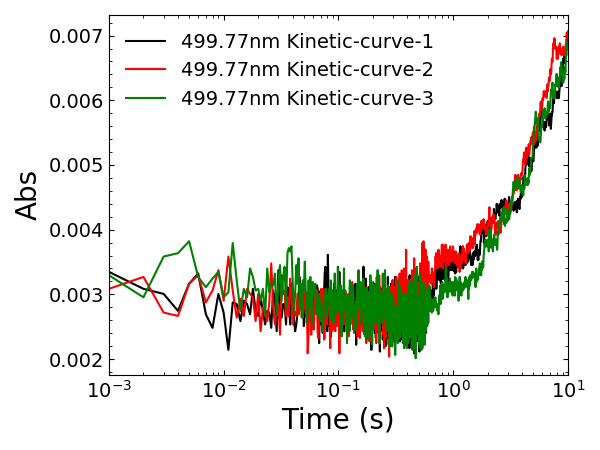

In [44]:
wavelength = 500
fig = plt.figure()
axis = fig.gca()
# plot curve 1
csvfile1 = 'average-sample-10s-1.csv'
df1 = get_selected_columns_as_dataframe(load_data(csvfile1), values=[wavelength])
plot_all_kinetic(df1, axis)

# plot curve 2
scale = 1
shift = 0
csvfile2 = 'average-sample-10s-2.csv'
df2 = get_selected_columns_as_dataframe(load_data(csvfile2), values=[wavelength]) * scale + shift
plot_all_kinetic(df2, axis)

# plot curve 3
scale = 1
shift = 0
csvfile3 = 'average-sample-10s-3.csv'
df3 = get_selected_columns_as_dataframe(load_data(csvfile3), values=[wavelength]) * scale + shift
plot_all_kinetic(df3, axis)

# set labels and legends
axis.set_xlabel('Time (s)')
axis.set_ylabel('Abs')
handles, labels = axis.get_legend_handles_labels()
# labels = ["10eq aKG + 20eq Hsub", "1eq aKG + 20eq Hsub", "10eq aKG + 20eq D-sub"]
from operator import add
labels_suffix = ["Kinetic-curve-1", "Kinetic-curve-2", 'Kinetic-curve-3']
labels = list( map(lambda s : s+'nm ', labels) )
labels = list( map(add, labels, labels_suffix) )
axis.legend(handles, labels).set_draggable(True)